# Introducing segment network
- Design of a new network SegmentNetwork layer where training parameters are x0,y0 .. xn,yn it has n-1 segments. 
- initialization: initialize the x0 and x1 based on min & max of x. - or should this be during forward?
- Training data selection: train for x where loss is max for faster .
- how do we make sure only node that has max loss adjust max? or is that auotmatic based on gradient?

## Observations after tests
1. Each node appears to train for corners in the data set (atleast for LeakyRELU)
2. Even for random training data (InfiniteRandomDataLoader) the NN appears to train node with lowest X values first them moves to higher.
3. Without normalizing f_quartic can lead to good training in 2000 steps by using ReduceLROnPlateau
4. Surprisingly normalizing data made things works for training. I had to add a weights_init function with gain of 10. Even then it took 10x to train (20000 steps) with finer control on LR

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## functions that we are trying to approximate

In [4]:
np.random.seed(10)

# y = ax^4 + bx^3 + cx^2 + dx + f
def f_quartic(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def f_inv_quartic(x):
    return 7 - f_quartic(x)
    
def f_semicircle(x):
    maxX = x.max()
    minX = x.min()
    radius = (maxX - minX)/2 
    center = (maxX + minX)/2 
    y = np.sqrt(np.abs(radius**2 - (x-center)**2))
    return y
    
def frand(y):
    return y + y*np.random.uniform(-0.1, 0.1, y.shape).astype('f')

def normalize(x):
    # normalize x & y
    x_factor = x.max() - x.min()
    if(x_factor == 0):
        x_factor = 1
    return x/x_factor

(1250,)

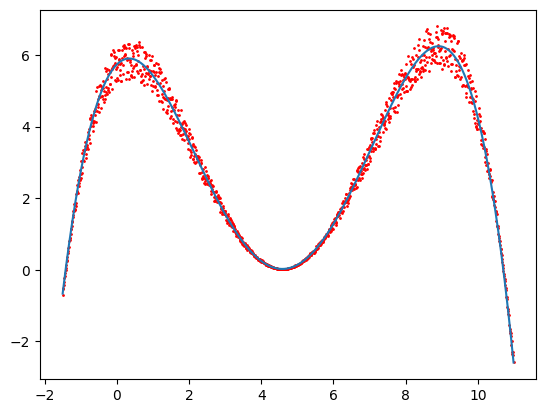

In [5]:
# show data for function 
f = f_quartic

xs = np.arange(-1.5, 11, .01)
ys = f(xs)
yrand = frand(ys)
plt.scatter(xs, yrand, color='red',s=1)
plt.plot(xs, ys)
xs.shape

torch.Size([1250, 1])

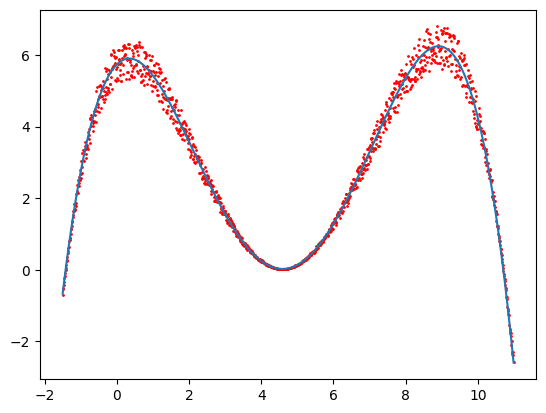

In [6]:
# Test with Tensor
xt = torch.tensor(xs.reshape(xs.shape[0],1), dtype=torch.float32)
yt = torch.tensor(ys.reshape(ys.shape[0],1), dtype=torch.float32)
ytrand = torch.tensor(yrand.reshape(yrand.shape[0],1), dtype=torch.float32)
plt.scatter(xt, ytrand, color='red',s=1)
plt.plot(xt, yt)
xt.shape

## Define Data Loaders (InfiniteRandom and ExtremeLossFirst)

In [7]:
from torch.utils.data.dataloader import DataLoader

class InfiniteRandomDataLoader:

    def __init__(self, dataset, loss, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch


In [8]:
""" ExtremeLossFirstDataloader:
    init should be called in every epoc (ie when we exhaust all samples).
    in init() we find out loss and order data in reverse order of loss
    next() fetches batches of data in order of sorting.
"""
class ExtremeLossFirstDataloader:

    def __init__(self, dataset, loss, **kwargs):
        # sort dataset based on the loss
        sortedloss, indices = torch.sort(loss, dim=-2,descending=True) #reverse sort loss
        sorted_dataset = torch.index_select(x, 0, torch.reshape(indices,(indices.shape[0],)))
        self.train_loader = DataLoader(sorted_dataset, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

In [9]:
""" TopLossClusterDataloader:
    init should be called in every epoc (ie when we exhaust all samples).
    in init() we find out loss and create batches that are near the top loss (+- batchsize/2).
"""
class TopLossClusterDataloader:

    def __init__(self, dataset, loss, batch_size, **kwargs):
        # sort dataset based on the loss
        sortedloss, indices = torch.sort(loss, dim=-2,descending=True) #reverse sort loss
        self.batch_size = batch_size
        self.make_set(indices, dataset)
        #self.train_loader = DataLoader(toploss_dataset, **kwargs)
        #self.data_iter = iter(self.train_loader)

    def make_set(self, indices, dataset):
        index = indices[0]
        start = max(0, index - int(self.batch_size/2))
        stop = min(indices.max(), index + int(self.batch_size/2)) -1
        if start-stop < self.batch_size:
            if(start == 0):
                stop = start + self.batch_size
            elif (stop == indices.max()):
                start = stop - self.batch_size

        self.toploss_dataset = dataset[start:stop+1]
        return 
        
    def next(self):
        #try:
        batch = self.toploss_dataset
        #except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            #self.data_iter = iter(self.train_loader)
            #batch = next(self.data_iter)
        return batch

In [10]:
# test TopLossClusterDataloader
#dataLoader = TopLossClusterDataloader
#batch_loader = dataLoader(dataset,loss=alllosses, batch_size=64, pin_memory=True, num_workers=1)
#batch_loader.next()

In [11]:
""" TopNLossFirstDataloader:
    init should be called in every epoc (ie when we exhaust all samples).
    in init() we find out loss and order data in reverse order of loss, we use only top 20% of the data with most loss.
    next() fetches batches of data in order of sorting.
"""
class TopNLossFirstDataloader:

    def __init__(self, dataset, loss, **kwargs):
        # sort dataset based on the loss
        sortedloss, indices = torch.sort(allloss,dim=-2,descending=True) #reverse sort loss
        sorted_dataset = torch.index_select(x, 0, torch.reshape(indices,(indices.shape[0],)))
        topNpct = 64 #int(sorted_dataset.shape[0]*.2)
        train_sampler = torch.utils.data.RandomSampler(sorted_dataset[0:topNpct], replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)
        
    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

# Define the neural network model

In [348]:
from torch import Tensor

class LinearSegment(nn.Module):
    __constants__ = ['in_features', 'segment_features']
    in_features: int
    segment_features: int
    x_param: Tensor
    y_param: Tensor

    def __init__(self, in_features: int, segment_features: int,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.segment_features = segment_features
        self.x_min = torch.zeros((1, in_features), requires_grad=False, **factory_kwargs)
        self.x_max = torch.ones((1, in_features), requires_grad=False, **factory_kwargs)
        self.x_param = nn.Parameter(torch.empty((self.segment_features + 1, self.in_features), **factory_kwargs))
        self.y_param = nn.Parameter(torch.empty((self.segment_features + 1, self.in_features), **factory_kwargs))
        self.reset_parameters(factory_kwargs)

    def reset_parameters(self, factory_kwargs) -> None:
        with torch.no_grad():
            nn.init.kaiming_uniform_(self.y_param, a=math.sqrt(5))
            
            self.x_param[0,:] = self.x_min
            self.x_param[-1,:] = self.x_max
            segment_width = (self.x_max - self.x_min)/self.segment_features
            for i in range(1,self.segment_features):
                self.x_param[i,:] = i*segment_width

        #print(self.x_param)
        #x_init = np.random.uniform(self.x_min, self.x_max,size=(self.segment_features + 1, self.in_features))
        #x_init_sorted = torch.sort(torch.tensor(x_init , **factory_kwargs), dim=-2).values
        #self.x_param = nn.Parameter(x_init_sorted)

    
    def old_forward(self, input: Tensor, is_training: bool = True) -> Tensor:
        #with torch.no_grad():
        
        # param clipping: ensure x_param are in ascending order only
        # during training it is possible that x_params are not ordered and are overlapping after optimizer.step()
        # this function fixes that problem when called from forward
        if is_training:
            input_min = input.min(dim=0).values.clone().detach()
            input_max = input.max(dim=0).values.clone().detach()
            self.x_min = torch.minimum(self.x_min,input_min)
            self.x_max = torch.maximum(self.x_max,input_max)
            
            # iterate through every row of self.x_param (it may have more than one row based on input dimensions)
            # make sure next column value is max of previous columns            
            # Create a cumulative max matrix
            cum_max_matrix = torch.zeros_like(self.x_param)
            cum_max_matrix[0,:] = self.x_min 
            cum_max_matrix[-1,:] = self.x_max
            self.x_param.data[-1,:] = self.x_max
            # Compute cumulative max
            for i in range(1, self.x_param.shape[0]):
                cum_max_matrix[i] = np.maximum(self.x_param.detach().numpy()[i], cum_max_matrix[i - 1])

            self.x_param.data = cum_max_matrix
        
        #calculate the base and perpendicular of each segment
        x_start = self.x_param[0:-1]
        x_end = self.x_param[1:]
        segment_widths = torch.abs(x_end - x_start)
       
        # find xi_base for each x value in the input tensor against each segment
        #print("input,x_start shape = ",input, x_start)
        input_expanded = input.unsqueeze(1)
        xi_bases = torch.abs(input_expanded - x_start) 
        #print("xi_bases shape, data = ",xi_bases.shape,xi_bases)
        
        # we also find the distance between x_end and x called x_extras.
        # if x falls between x_start and x_end then xi_bases + xi_extras should not be > segment_width
        # this is how we can find the correct segment for each x.
        xi_tot = torch.abs(x_end - input_expanded) + xi_bases
        #print("xi_tot,segment_widths")
        #print(xi_tot,segment_widths)
        x_mask = Tensor.le(xi_tot,segment_widths)
        #print(xi_bases*x_mask)
        x_factor = xi_bases*x_mask*segment_widths # x_factor is the propotional growth per segment
        #print("x_factor\n",x_factor)
        y_start = self.y_param[0:-1]
        y_end = self.y_param[1:]
        y_base = y_end - y_start
        #print("y_base.shape,x_factor.shape\n",y_base.shape,x_factor.shape)
        y_incr = y_base*x_factor
        #print("y_incr\n",y_incr.shape,y_incr)
        #print("y_start\n",y_start.shape,y_start)
        y_new = (y_incr + y_start)*x_mask
        y_new = y_new.sum(dim=-2)
        #print("y_new\n",y_new.shape,y_new)
        #y_new = ((y_incr + y_start)*x_mask).sum(dim=-1)
        return y_new

    # extremely slow and backprop doesn't work.
    def old2_forward(self, input: Tensor) -> Tensor: 
        # param clipping: ensure x_param are in ascending order only
        # during training it is possible that x_params are not ordered and are overlapping after optimizer.step()
        # this function fixes that problem when called from forward
        if self.training:
            input_min = input.min(dim=0).values.clone().detach()
            input_max = input.max(dim=0).values.clone().detach()
            self.x_min = torch.minimum(self.x_min,input_min) #no grad_fn needed
            self.x_max = torch.maximum(self.x_max,input_max) #no grad_fn needed   

            # iterate through every row of self.x_param (it may have more than one row based on input dimensions)
            # make sure next column value is max of previous columns            
            # Create a cumulative max matrix
            cum_max_matrix = torch.zeros_like(self.x_param)
            cum_max_matrix[0,:] = self.x_min 
            cum_max_matrix[-1,:] = self.x_max
            self.x_param.data[-1,:] = self.x_max
            # Compute cumulative max
            for i in range(1, self.x_param.shape[0]):
                cum_max_matrix[i] = np.maximum(self.x_param.detach().numpy()[i], cum_max_matrix[i - 1])

            self.x_param.data = cum_max_matrix
            # self.x_param requires_grad = True, grad_fn=None
            #print("self.x_param.requires_grad = ",self.x_param.requires_grad, self.x_param.grad_fn)

        y = torch.ones([input.shape[0],1]) # initialize y same number of rows like x but 1 column
        y.requires_grad = True
        # y requires_grad = True, grad_fn=None

        #loop thru every row of x, find out its x_segment, find y using trig.
        #print (f"self.x_param.data = {self.x_param.data}")
        for row in range(len(input[:,0])):
            xi = input[row, 0]
            for segment in range(len(self.x_param.data[:,0])):
                #segment is integer so no grad
                x_start = self.x_param[segment,0]
                y_start = self.y_param[segment,0]
                # y_start.requires_grad =  True <SelectBackward0 object at 0x157fe4c10>
                y_value = y_start # default
                #print("y_value.requires_grad = ",y_value.requires_grad, y_value.grad_fn)
                if x_start >= xi:
                    if segment > 0 and segment < len(self.x_param.data)-1: # calculate y as a ratio using trig
                        #print("test ",segment, len(self.x_param.data))
                        x_next = self.x_param[segment+1,0]
                        #print("x_next.requires_grad = ",x_next.requires_grad, x_next.grad_fn)
                        y_next = self.y_param[segment+1,0]
                        #print("y_next.requires_grad = ",y_next.requires_grad, y_next.grad_fn)
                        base = x_next - x_start
                        #print("base.requires_grad = ",base.requires_grad, base.grad_fn)
                        height = y_next - y_start
                        #print("height.requires_grad = ",height.requires_grad, height.grad_fn)
                        if base == 0: # if both points are the same use same y
                            y_value = y_start
                        else:
                            y_value = (xi - x_start) * height/base  
                    
                    #print("y_value.requires_grad = ",y_value.requires_grad, y_value.grad_fn)
                    #print(f"for {xi} found segment {segment}, y = {y_value}")
                    # We cannot assign y_value to an element of y as that won't preserve gradient
                    # so the work around if to use a mask (seems to have worked last time)
                    # Scatter values at specific indices
                    indices =  torch.tensor([[segment]])                    
                    values = torch.tensor([[y_value]], dtype=y.dtype)
                    values.requires_grad = True
                    #print("values.requires_grad = ",values.requires_grad, values.grad_fn)
                    y = y.scatter(0, indices, values)

                    break
            #print("for row = ", row, "xi = ",xi,"\n y = ",y)            
        return y  

    def forward(self, input: Tensor) -> Tensor: 
        # A simple forward implementation ofr single row input
        if self.training:
            input_min = input.min(dim=0).values.clone().detach()
            input_max = input.max(dim=0).values.clone().detach()
            self.x_min = torch.minimum(self.x_min,input_min) #no grad_fn needed
            self.x_max = torch.maximum(self.x_max,input_max) #no grad_fn needed   

            # iterate through every row of self.x_param (it may have more than one row based on input dimensions)
            # make sure next column value is max of previous columns            
            # Create a cumulative max matrix
            cum_max_matrix = torch.zeros_like(self.x_param)
            cum_max_matrix[0,:] = self.x_min 
            cum_max_matrix[-1,:] = self.x_max
            self.x_param.data[-1,:] = self.x_max
            # Compute cumulative max
            for i in range(1, self.x_param.shape[0]):
                cum_max_matrix[i] = np.maximum(self.x_param.detach().numpy()[i], cum_max_matrix[i - 1])

            self.x_param.data = cum_max_matrix
            print("self.x_param.data after adjustemnt",self.x_param.data)
        xi = input[0:1,0:1] # we want only 1st value but keep shape
        segment = 0
        found = False
        for (x_start,y_start) in zip(self.x_param, self.y_param):
        #for segment in range(len(self.x_param.data)):
            # y_start.requires_grad =  True <SelectBackward0 object at 0x157fe4c10>
            #print("y_start.requires_grad = ",y_start.requires_grad, y_start.grad_fn)
            if x_start >= xi and segment > 0 and segment < len(self.x_param.data)-1: # calculate y as a ratio using trig
                #print("test ",segment, len(self.x_param.data))
                x_next = self.x_param[segment+1,0]
                #print("x_next.requires_grad = ",x_next.requires_grad, x_next.grad_fn)
                y_next = self.y_param[segment+1,0]
                #print("y_next.requires_grad = ",y_next.requires_grad, y_next.grad_fn)
                base = x_next - x_start
                #print("base.requires_grad = ",base.requires_grad, base.grad_fn)
                height = y_next - y_start
                #print("height.requires_grad = ",height.requires_grad, height.grad_fn)
                if base > 0: # if both points are the same use same y, avoid divide by 0
                    y_value = (xi - x_start) * height/base 
                    #print("at base > 0")
                    found = True
                    break 
            segment += 1

        if(not found):
            #print("segment = ", segment, x_start, xi )
            #if(x_start != 0 and xi != 0):
            #    y_value = y_start * xi/x_start
            # looks like there is no backprop needed as we don't need model adjust params to predict y
            # it is value of the param itself.
            y_value = y_start.unsqueeze(0) # we reached the last segment without assigning value
            #print("y_start.requires_grad = ",y_start.requires_grad, y_start.grad_fn)
            
        return y_value
            
            
    def extra_repr(self) -> str:
        return f'in_features={self.in_features}, out_features={self.segment_features}'

### Testing

In [248]:
# create test data
xtest = np.array([-.21, .2, .5, .755, .8, .9, 1.08])
ytest = f(xtest)
x = torch.tensor((xtest.reshape(xtest.shape[0],1)), dtype=torch.float32) 
y = torch.tensor((ytest).reshape(ytest.shape[0],1), dtype=torch.float32)
xtest.shape, x.shape, y.shape

((7,), torch.Size([7, 1]), torch.Size([7, 1]))

In [67]:
x[0:1,0:1], x[0:1,0:1].shape

(tensor([[-0.2000]]), torch.Size([1, 1]))

In [ ]:
criterion = nn.MSELoss(reduction='mean')

In [182]:
#define model
m = LinearSegment(1,4)
m.train()

LinearSegment(in_features=1, out_features=4)

In [183]:
#forward pass
m.train()
y_new = m.forward(x) 

In [184]:
#calculate loss
loss = criterion(y_new, y[0:1,0:1])

In [172]:
y_new.shape, y[0:1,0:1].shape

(torch.Size([1, 1]), torch.Size([1, 1]))

In [185]:
loss

tensor(53.1087, grad_fn=<MseLossBackward0>)

In [186]:
# Backward and optimize
m.zero_grad(set_to_none=True)
loss.backward()

In [231]:
from torchviz import make_dot


# Generate a Graphviz object from the computation graph
graph = make_dot(loss, params=dict(m.named_parameters())) 

# Save the graph as a PDF or any other format if needed
graph.render("m_computation_graph")

'm_computation_graph.pdf'

In [329]:
def step(self):
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    # Update param with gradient
                    param.data.add_(param.grad.data, -self.lr)


In [349]:
#define model
lr=.01
optimizer = torch.optim.AdamW(m.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
m = LinearSegment(1,4)
m.train()

LinearSegment(in_features=1, out_features=4)

In [355]:
# loop
for i in range(0,x.shape[0]):
    #print (x[i:i+1,:], y[i:i+1,:])
    y_new = m.forward(x[i:i+1,:]) 
    loss = criterion(y_new, y[i:i+1,:])
    m.zero_grad(set_to_none=True)
    print("i:",i,"x=",x[i:i+1,:])
    loss.backward()
    print("loss = ",loss.detach())
    print (y_new.shape)
    #optimizer.step()
    for p in m.parameters():
        if(p.grad is not None):
            p.data += p.grad.data -lr
    #print(m.x_param, m.y_param)
    break
    

self.x_param.data after adjustemnt tensor([[-0.2100],
        [ 8.4307],
        [ 8.4307],
        [ 8.4307],
        [ 8.4307]])
i: 0 x= tensor([[-0.2100]])
loss =  tensor(370.2587)
torch.Size([1, 1])


In [356]:
m.x_param.data

tensor([[-0.2100],
        [ 8.4307],
        [ 8.4307],
        [ 8.4307],
        [ 8.4307]])

In [324]:
m.x_param.data += -lr
m.x_param.data

tensor([[-0.3100],
        [ 0.1500],
        [ 0.4000],
        [ 0.6500],
        [ 0.9800]])

In [319]:
for p in m.parameters():
    print (p.grad)

None
tensor([[  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [-10.7761]])


In [303]:
optimizer.step()
for p in m.parameters():
    print (p[:,0].detach())

tensor([-0.2100,  0.2500,  0.5000,  0.7500,  1.0000])
tensor([ 0.3066,  0.7827,  0.7977, -0.2089, -0.2908])


In [ ]:
# testing 2D input
m = LinearSegment(2,4)

In [ ]:
y = m.forward(x2d, True)

In [ ]:
m.x_param

In [ ]:
x2d.min(),x2d.max()

In [ ]:
import torch

tensor1 = torch.tensor([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]])
tensor2 = torch.tensor([[15, 16], [17, 18], [19, 20], [21, 22]])

expanded_tensor1 = tensor1.unsqueeze(1)  # Expand tensor1 along the second dimension (columns)

subtracted_tensor = expanded_tensor1 - tensor2
print(subtracted_tensor.shape)


In [ ]:
segment_widths =  torch.tensor([[0.2865],
        [0.2249],
        [0.3031],
        [0.4855]], dtype=torch.float64)
xi_tot =  torch.tensor([[0.2865, 0.7979, 1.3259, 2.1145],
        [0.5135, 0.2249, 0.5259, 1.3145],
        [1.1135, 0.6021, 0.3031, 0.7145],
        [1.6235, 1.1121, 0.5841, 0.4855],
        [1.7135, 1.2021, 0.6741, 0.4855],
        [1.9135, 1.4021, 0.8741, 0.4855],
        [2.3135, 1.8021, 1.2741, 0.4855]], dtype=torch.float64)
x_mask = xi_tot <= segment_widths.T
xi_bases =  torch.tensor([[0.0000, 0.2865, 0.5114, 0.8145],
        [0.4000, 0.1135, 0.1114, 0.4145],
        [0.7000, 0.4135, 0.1886, 0.1145],
        [0.9550, 0.6685, 0.4436, 0.1405],
        [1.0000, 0.7135, 0.4886, 0.1855],
        [1.1000, 0.8135, 0.5886, 0.2855],
        [1.3000, 1.0135, 0.7886, 0.4855]], dtype=torch.float64)
x_factor = xi_bases*x_mask/segment_widths.T #factor
x_factor

In [ ]:
y_start = m.y_param[0:-1]
y_end = m.y_param[1:]
y_base = (y_end - y_start)
y_base

In [ ]:
y_base.shape

In [ ]:
y_incr = y_base.T*x_factor

In [ ]:
((y_incr + y_start.T)*x_mask).sum(dim=-1)

In [ ]:
y_start

In [ ]:
y_start + torch.sum(y_incr,dim=-2).reshape(y_start.shape)

In [ ]:
m.x_param.data[:,0]

In [ ]:
x_base = x_end - x_start
x_base

In [ ]:
x, x_start.T

In [ ]:
x - x_start.T #subtract x from start

In [ ]:
x_end.T -x

In [ ]:
xi_base = torch.abs((x_end.T -x) - (x - x_start.T))
xi_base

In [ ]:
x_base = x_end - x_start
x_base.T

In [ ]:
tmp = xi_base[x_base.T > xi_base]
print(tmp)


In [ ]:
m.x_param

In [ ]:
m = LinearSegment(2,4)
x_base, y_base = m.forward(x2d)

In [ ]:
m.x_param,m.y_param

In [ ]:
m.x_param.detach().shape,x.shape

In [ ]:
m.x_param > x

In [ ]:
true_indices[0]

In [ ]:
true_indices[1]

In [ ]:
true_indices.shape

In [ ]:
# Find the indices of True values
cmp = comparison_result.to(torch.float32) * 1.0
cmp

In [ ]:
first_true_indices = torch.nonzero(cmp)
cmp, first_true_indices[:, 1]

In [ ]:
cmp

In [ ]:
x = torch.tensor([[True, False, True], [False, True, False]])
true_indices = torch.where(x)
true_indices

In [ ]:
true_indices[1]

In [ ]:
torch.sort(tensor1, dim=-2).values

In [ ]:
x = torch.tensor([[True, False, True], [False, True, False]])
true_indices = torch.nonzero(x)

In [ ]:
true_indices

In [ ]:
test = torch.cat((test,y.detach()),dim=1)
test.shape

In [ ]:
test.min(dim=0).values

In [ ]:
# Replaced fc2 linear layer with sum but didn't train well. FAILED EXPERIMENT
class OneHiddenLayerSumNet(nn.Module):
    def __init__(self, input_size, hidden1_size, output_size):
        super(OneHiddenLayerSumNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        return torch.sum(x, 1).reshape(x.shape[0],1) 

In [ ]:
# TODO Replace leaky_relu with double sided leaky relu so the slope is confined between two biases - EXPERIMENT
class OneHiddenLayerDlruNet(nn.Module):
    def __init__(self, input_size, hidden1_size, output_size):
        super(OneHiddenLayerSumNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        return torch.sum(x, 1).reshape(x.shape[0],1) 

In [38]:
# observation: Training is very sensitive to negative_slope, if you go outside 0.09 to 1.1 range for negative slope model stops learning
## couldn't train after normalizing
class OneHiddenLayerNet(nn.Module):
    def __init__(self, input_size, hidden1_size, output_size):
        super(OneHiddenLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        #x = x@self.fc1.weight.T + self.fc1.bias # this is what self.fc1(x) does
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.fc2(x)
        return x

In [ ]:
class TwoHiddenLayerNet(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(TwoHiddenLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = self.fc3(x)
        return x

In [ ]:
# My activation function which is like inverse leaky_relu. it has a trainable parameter that chops the linear function output
# Chop(x) = min(x, drop_slope*x + alpha)
class Chop(nn.Module):
    r"""
    Chop(input, drop_slope=0.1)
    """
    def __init__(self, in_features, drop_slope: float = 0.1):
        super(Chop, self).__init__()
        self.drop_slope = drop_slope
        # Define a trainable parameter
        self.alpha = nn.Parameter(5.*torch.ones(1, in_features))  # Initialized with ones, but you can choose a different initialization
    def forward(self, x):
        y = torch.min(x,  self.alpha)
        y[y == self.alpha] = 0
        return y


In [ ]:
# Hidden layer with Chop 
# Note ChopNet works, trains slowly and needs more understanding of why or how to train quickly
#needed normalizing?
class OneHiddenLayerChopNet(nn.Module):
    def __init__(self, input_size, hidden1_size, output_size):
        super(OneHiddenLayerChopNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.ch1 = Chop(hidden1_size, drop_slope=0.1)
        self.fc2 = nn.Linear(hidden1_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ch1(x)
        x = self.fc2(x)
        return x

#### testing

In [ ]:
tensor_1d = torch.rand(4)

In [ ]:
tensor_1d[2] = 10

In [ ]:
tensor_1d

In [ ]:
torch.min(tensor_1d, torch.tensor([2]) + torch.tensor([0.1])*tensor_1d) 

In [ ]:
torch.min(tensor_1d, torch.tensor([0.1])*tensor_1d + torch.tensor([0.5])) 

In [ ]:
#model.ch1.alpha, tensor_1d

In [ ]:
#model.ch1.forward(tensor_1d)

### Model helper functions

In [ ]:
# for single hidden layer model each neuron trains for one vertex (ie change in slope) if we use RELU like functions
# The X coordinate for this vertex is given by -1*bias/weight for each neuron. This function returns that value
# Y location is a bit tricky as it is a sum of all Y for each neuron equation. That is what the function predicts
#
def get_vertices(model):
    with torch.no_grad():
        x_for_vertices = np.zeros_like(model.fc1.bias.detach().numpy())
        bias = model.fc1.bias.detach().numpy()
        weight = model.fc1.weight.detach().reshape(model.fc1.out_features).numpy()
        for i in range(bias.shape[0]):
            x_for_vertices[i] = -1*bias[i]/weight[i]
    return x_for_vertices

#capture model's weights and biases so we can see training progress
def get_params(model):
   # x_for_vertices = np.zeros_like(model.fc1.bias.detach().numpy())
   # fc1_bias = model.fc1.bias.detach().numpy()
   # fc1_weight = model.fc1.weight.detach().reshape(model.fc1.out_features).numpy()
   # fc2_bias = model.fc2.bias.detach().numpy()
   # fc2_weight = model.fc2.weight.detach().reshape(model.fc1.out_features).numpy()
   # params = np.array([fc1_weight])
   # params = np.append(params,fc1_bias)
   # params = np.append(params,fc2_weight)
   # params = np.append(params,fc2_bias)

    return np.array(params).reshape(1,params.size)

# Define your weight initialization function - Didn't work well. only default init (without this function worked best)
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.1)

## Model Training with random data loader

### init training

In [240]:
# init training
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

torch.manual_seed(10)
#model = OneHiddenLayerNet(1, 4, 1)
model = LinearSegment(1,4)
#model.apply(weights_init)

# Capture params after initialization
model_params = []
model_params.append(copy.deepcopy(model.state_dict()))

dataLoader = InfiniteRandomDataLoader

# init optimizer
criterion = nn.MSELoss(reduction='mean')

# testing if normalizing data help train faster. unfortunately it was worse
#xs = normalize(xs) # couldn't train after normalizing
#ys = normalize(ys)

x = torch.tensor((xs).reshape(xs.shape[0],1), dtype=torch.float32)
ytest = torch.tensor((ys).reshape(ys.shape[0],1), dtype=torch.float32) # y is from function / not randomized
# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x, ytest)

#initialize training params
step = 0
losses = np.array([])
#with torch.no_grad():
#    y = model(x)
#    total_mean_loss = criterion(y, ytest)
#    losses = np.append(losses, total_mean_loss)
     
# optimizer an scheduler
lr=.1
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=.5, patience=500,threshold=0.001, threshold_mode='rel', cooldown=0, 
                                                 min_lr=0, eps=1e-08, verbose=True) # let us try scheduler to reduce learning rate

### Training loop

In [241]:
# training loop

best_loss = .01
prev_total_mean_loss = 100
max_steps = 300

model.train() # We use this variable for training
# init dataloader
batch_loader = dataLoader(dataset,loss=None, batch_size=1, pin_memory=True, num_workers=1)

while True:
    t0 = time.time()
    # get the next batch, ship to device, and unpack it to input and target
    X, Y = batch_loader.next()
    #check for NaN
    if math.isnan(Y.mean()):
        print ("Breaking for NaN")
        break

    # Forward pass
    ypred = model(X)

    # Calculate the loss
    #loss = criterion(ypred, Y)
    loss = criterion(ypred, Y[0:1,0:1])
 
    # Backward and optimize
    model.zero_grad(set_to_none=True)
    loss.backward()

    # Evaluate model after this optimizer.step
    # we evaluate on complete data
    #with torch.no_grad():
    #    y = model(x)
    #    total_mean_loss = criterion(y, ytest)
    total_mean_loss = loss
    losses = np.append(losses, total_mean_loss)

    
    optimizer.step() #not needed is we have scheduler, I think
    step += 1
    scheduler.step(total_mean_loss)
    t1 = time.time()

    # store params (weights and biases) after each training step
    #if step % 10 == 0:
    model_params.append(copy.deepcopy(model.state_dict()))
             
    # logging
    #if step % 100 == 0:         
    print(f"step {step} | loss {loss:.4f} | total_mean_loss {total_mean_loss:.4f} | step time {(t1-t0)*1000:.2f}ms")

    # termination conditions
    if max_steps >= 0 and step % max_steps == 0:
        break
        
    #if total_mean_loss.mean() < best_loss:
        break

    #if total_mean_loss.mean() > prev_total_mean_loss*1.5:
    #    break #we may want to change learning rate

    prev_total_mean_loss = total_mean_loss


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

### Print model computation graph
very useful to debug if backprop is working when you create your own modules

In [165]:
#!pip install torchviz
from torchviz import make_dot


# Generate a Graphviz object from the computation graph
graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
graph.render("model_computation_graph")

'model_computation_graph.pdf'

 prev_total_mean_loss  tensor(2.8932)


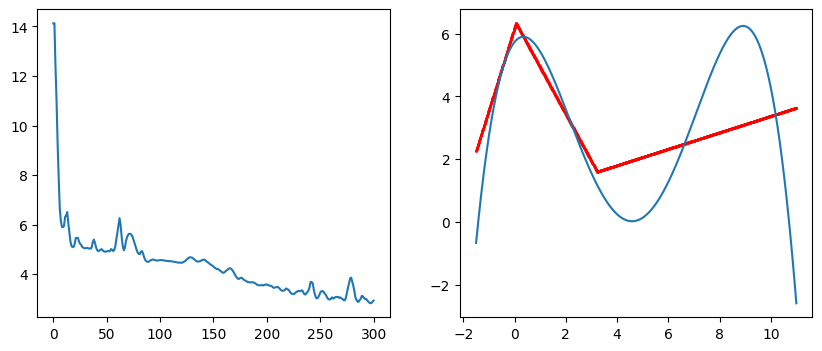

In [42]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 4) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
print (" prev_total_mean_loss ",prev_total_mean_loss)
ax1.plot(losses)

# plot trained model
y = model(x)
yout = y.data.reshape(xs.shape[0])
ax2.plot(xs, ys)
ax2.scatter(xs, yout, color='red', s=1)

# Display the plot
plt.show()

## Analyzing model parameters and reconstructing graph with model parameters

### Drawing animation showing how training progress

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(ys.min()-1, ys.max()+1)
ax.plot(xs, ys)
scatter = ax.scatter([], [], c='r', s=1)  # Initialize an empty scatter plot

def animate(i):
    model.load_state_dict(model_params[i])
    with torch.no_grad():
        model.eval() # be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.
        y = model(x)
    yout = y.data.reshape(xs.shape[0])
    #ax.scatter(xs, yout, color='red', s=1)
    scatter.set_offsets(np.column_stack((xs, yout)))
    ax.set_title(f"Epoc {i*10}, Loss {losses[1*(i)]:.4f}")

anim = FuncAnimation(fig, animate, frames=range(0,len(model_params)))

In [ ]:
# Save animation if necessary
anim.save("animation.gif")

In [ ]:
from IPython.display import HTML
HTML(anim.to_jshtml())

### Analyze model parameter changes during training

In [30]:
#what are the model parameters?
print(f"Total parameters = {len(model_params)}")
print(model_params[0],model_params[-1])

Total parameters = 301
OrderedDict([('x_param', tensor([[0.0000],
        [0.2500],
        [0.5000],
        [0.7500],
        [1.0000]])), ('y_param', tensor([[-0.0838],
        [-0.0343],
        [-0.3750],
        [ 0.2300],
        [-0.5721]]))]) OrderedDict([('x_param', tensor([[-1.5000],
        [ 0.2500],
        [ 0.5000],
        [ 0.7500],
        [10.9900]])), ('y_param', tensor([[-0.0838],
        [-0.0343],
        [-0.3750],
        [ 0.2300],
        [-0.5721]]))])


In [31]:
# Each param is an OrderedDict with two elements with key 'y_param' and 'x_param'
x_params = []
y_params = []
for i in range(len(model_params)):
    x_params.append(model_params[i]['x_param'][:,0].numpy())
    y_params.append(model_params[i]['y_param'][:,0].numpy())
    
x_params = np.array(x_params)
y_params = np.array(y_params)

In [32]:
x_params

array([[ 0.  ,  0.25,  0.5 ,  0.75,  1.  ],
       [-1.5 ,  0.25,  0.5 ,  0.75, 10.99],
       [-1.5 ,  0.25,  0.5 ,  0.75, 10.99],
       ...,
       [-1.5 ,  0.25,  0.5 ,  0.75, 10.99],
       [-1.5 ,  0.25,  0.5 ,  0.75, 10.99],
       [-1.5 ,  0.25,  0.5 ,  0.75, 10.99]], dtype=float32)

In [33]:
xs.min(),xs.max(),x_params.min(),x_params.max()

(-1.5, 10.99000000000001, -1.5, 10.99)

In [34]:
ys.min(),ys.max(),y_params.min(),y_params.max()

(-2.5918998658922936, 6.2456298370589005, -0.5721054, 0.23004329)

In [35]:
y_params

array([[-0.08383071, -0.03428686, -0.37500334,  0.23004329, -0.5721054 ],
       [-0.08383071, -0.03428686, -0.37500334,  0.23004329, -0.5721054 ],
       [-0.08383071, -0.03428686, -0.37500334,  0.23004329, -0.5721054 ],
       ...,
       [-0.08383071, -0.03428686, -0.37500334,  0.23004329, -0.5721054 ],
       [-0.08383071, -0.03428686, -0.37500334,  0.23004329, -0.5721054 ],
       [-0.08383071, -0.03428686, -0.37500334,  0.23004329, -0.5721054 ]],
      dtype=float32)

In [36]:
model.x_param.data,model.y_param.data

(tensor([[-1.5000],
         [ 0.2500],
         [ 0.5000],
         [ 0.7500],
         [10.9900]]),
 tensor([[-0.0838],
         [-0.0343],
         [-0.3750],
         [ 0.2300],
         [-0.5721]]))

In [213]:
for (x,y) in zip(model.x_param.data,model.y_param.data):
    print (x.unsqueeze(0).shape,y)

torch.Size([1, 1]) tensor([-0.0838])
torch.Size([1, 1]) tensor([-0.0343])
torch.Size([1, 1]) tensor([-0.3750])
torch.Size([1, 1]) tensor([0.2300])
torch.Size([1, 1]) tensor([-0.5721])


In [216]:
z = zip(model.x_param.data)

In [ ]:
z

In [ ]:
model(model.x_param.data)

### debugging the forward path

In [ ]:
xt = np.array([0, 1, 2, 5, 10])
input = torch.tensor((xt).reshape(xt.shape[0],1), dtype=torch.float64)
ytest = model(input)
input, ytest

In [ ]:
#calculate the base and perpendicular of each segment
x_start = model.x_param[0:-1]
x_end = model.x_param[1:]
segment_widths = torch.abs(x_end - x_start)
x_start, x_end, segment_widths

In [ ]:
input_expanded = input.unsqueeze(1)
xi_bases = torch.abs(input_expanded - x_start) 
print(f"xi_bases shape, data \n {xi_bases.shape} ]\n {xi_bases}")

In [ ]:
torch.abs(x_end - input_expanded)

In [ ]:
xi_tot = torch.abs(x_end - input_expanded) + xi_bases
xi_tot,segment_widths

In [ ]:
x_mask = Tensor.le(xi_tot,segment_widths)
x_mask

In [ ]:
with torch.no_grad():
            input_min = input.min(dim=0).values.clone().detach()
            input_max = input.max(dim=0).values.clone().detach()
            self.x_min = torch.minimum(self.x_min,input_min)
            self.x_max = torch.maximum(self.x_max,input_max)
            #copy x_mon & x_max to the x_params
            self.x_param[0,:] = self.x_min
            self.x_param[-1,:] = self.x_max

        #calculate the base and perpendicular of each segment
        x_start = self.x_param[0:-1]
        x_end = self.x_param[1:]
        segment_widths = torch.abs(x_end - x_start)
       
        # find xi_base for each x value in the input tensor against each segment
        #print("input,x_start shape = ",input, x_start)
        input_expanded = input.unsqueeze(1)
        xi_bases = torch.abs(input_expanded - x_start) 
        #print("xi_bases shape, data = ",xi_bases.shape,xi_bases)
        
        # we also find the distance between x_end and x called x_extras.
        # if x falls between x_start and x_end then xi_bases + xi_extras should not be > segment_width
        # this is how we can find the correct segment for each x.
        xi_tot = torch.abs(x_end - input_expanded) + xi_bases
        #print("xi_tot,segment_widths")
        #print(xi_tot,segment_widths)
        x_mask = Tensor.le(xi_tot,segment_widths)
        #print(xi_bases*x_mask)
        x_factor = xi_bases*x_mask*segment_widths # x_factor is the propotional growth per segment
        #print("x_factor\n",x_factor)
        y_start = self.y_param[0:-1]
        y_end = self.y_param[1:]
        y_base = y_end - y_start
        #print("y_base.shape,x_factor.shape\n",y_base.shape,x_factor.shape)
        y_incr = y_base*x_factor
        #print("y_incr\n",y_incr.shape,y_incr)
        #print("y_start\n",y_start.shape,y_start)
        y_new = (y_incr + y_start)*x_mask
        y_new = y_new.sum(dim=-2)
        #print("y_new\n",y_new.shape,y_new)
        #y_new = ((y_incr + y_start)*x_mask).sum(dim=-1)

In [ ]:
# function to calulates forward pass for first layer and chop
def nnforward(x):
    with torch.no_grad():
        l1 = model.ch1(model.fc1(torch.tensor([x]))).numpy()[0]
        c1 = model.fc2.weight.numpy()[0]
        # individually multiple each value of l1 with c1 to get effect of each l1
        s = np.empty_like(l1)
        i=0
        for a,b in zip(l1, c1):
            s[i] = a*c1
            i+=1
    return s

def nnforward_exp(x):
    with torch.no_grad():
        l1 = model.ch1(torch.tensor([x])).numpy()[0]
        c1 = model.fc2.weight.numpy()[0]
        # individually multiple each value of l1 with c1 to get effect of each l1
        s = np.empty_like(l1)
        i=0
        for a,b in zip(l1, c1):
            s[i] = a*1
            i+=1
    return s
# test nnforward(10.)

In [ ]:
# Create an empty NumPy array
result_array = np.empty((0, model.fc1.out_features))  

for i in range(xs.shape[0]):
    new_data = nnforward_exp(float(xs[i]))
    result_array = np.append(result_array, [new_data], axis=0)

for i in range(model.fc1.out_features):
    plt.scatter(xs, result_array[:,i],s=1,label=i)

plt.legend()
plt.show()

In [ ]:
result_array.shape,new_data.shape

In [ ]:
result_array[:1000,0]

In [ ]:
range(xs.shape[0])

## Analyzing gradient of trained model for each X

In [ ]:
# load old model parameters
model.load_state_dict(model_params[0])
# We have to do model evaluation with grad
model.eval() # be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.
y0 = model(x)
y0.retain_grad()
total_loss = criterion(y0, ytest)
total_loss.backward()
#x0_grad = x.grad.numpy()
y0_grad = y0.grad.numpy()

In [ ]:
# Final training
model.load_state_dict(model_params[4])
# We have to do model evaluation with grad
model.eval() # be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.
yf = model(x)
yf.retain_grad()
total_loss = criterion(yf, ytest)
total_loss.backward()
#xf_grad = x.grad.numpy()
yf_grad = yf.grad.numpy()

### Obsesrvations & Learnings from y.grad analysis
Observations: yf.grad.numpy() appears to be very critical. we are minimizing this at every step.
 y0.grad.numpy() from an untrained model probably gives a very good glimpse of where the gaps are (same as loss)
 and where we should focus training.

Isn't yf.grad only showing loss at each x? So are we saying only train for value of X where loss is higher?

Another learning can be used to design a new network SegmentNetwork where training parameters are x0,y0 .. xn,yn
it has n-1 segments. we initialize the x0 and x1 based on min & max of x. 
we should also train for x where loss is max.
how do we make sure only node that has max loss adjust max? or is that auotmatic based on gradient?


In [ ]:
matplotlib.rcParams['figure.figsize'] = (8, 8) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(xs,ys)
ax1.plot(xs,y0.detach().numpy(), color='r')
ax1.plot(xs,yf.detach().numpy(), color='g')

ax2.plot(xs,y0_grad, color='r')
ax2.plot(xs,yf_grad, color='g')
#ax2.set_ylim(-0.01,0.01)
ax2.axhline(y=0, color='k')

In [ ]:
# derivative of y = f(x)
# y = a*x**4 + b*x**3 + c*x**2 + d*x + f
def first_derivative(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return 4*a*x**3 + 3*b*x**2 + 2*c*x + d

def second_derivative(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return 12*a*x**2 + 6*b*x + 2*c

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8, 6) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(x,ytest)
ax2.plot(x,first_derivative(x))
ax2.plot(x,second_derivative(x))

# Scratch / Graveyard

In [ ]:
def chop(x):
    drop_slope = torch.tensor([0.1])
    alpha = torch.tensor([5.])
    y = torch.min(x,  alpha)
    y[y == alpha] = 0
    return y

In [ ]:
Xt = torch.tensor(range(10))
Yt = chop(Xt)
plt.plot(Xt, Yt)

In [ ]:
Xt, Yt

In [ ]:
model_params[0],model_params[-1]

In [ ]:
with torch.no_grad():
    x = 10.
    print(model.ch1(model.fc1(torch.tensor([x]))).numpy())
    print(model.fc2.weight.numpy())
    print((model.ch1(model.fc1(torch.tensor([x])))@model.fc2.weight.T).numpy(), model.fc2.bias.numpy())
    print(model(torch.tensor([x])).numpy())

In [ ]:
with torch.no_grad():
    X = model.ch1(model.fc1(torch.tensor([x]))).numpy()
    Y = model.fc2.weight.numpy()

In [ ]:
s = 0
for a,b in zip(X[0], Y[0]):
    s += a*b
    print(a*b,a,b)
print (s)

In [ ]:
for name, param in model.named_modules():
    print (f'name = {name}')
    print (f'param = {param}')

In [ ]:
# Show values of weights and biases
for name, param in model.named_parameters():
    if 'weight' in name:
        print(name, '\n', param)
    elif 'bias' in name:
        print(name, '\n', param)

In [ ]:
# Fetch model parameter by name
def fetch_param(name_in):
    for name, param in model.named_parameters():
        if name == name_in:
            weight_tensor = param
            break
    return weight_tensor.detach().numpy()

#leaky relu 
def lru(x):
    if(x < 0):
        return x*0.1
    return x
    
def nnforward(x):
    z11 = lru(x*fetch_param('fc1.weight')[0][0] + fetch_param('fc1.bias')[0])
    z12 = lru(x*fetch_param('fc1.weight')[1][0] + fetch_param('fc1.bias')[1])
    z13 = lru(x*fetch_param('fc1.weight')[2][0] + fetch_param('fc1.bias')[2])
    z14 = lru(x*fetch_param('fc1.weight')[3][0] + fetch_param('fc1.bias')[3])
    
    y1 = fetch_param('fc2.weight')[0,0] * z11
    y2 = fetch_param('fc2.weight')[0,1] * z12
    y3 = fetch_param('fc2.weight')[0,2] * z13
    y4 = fetch_param('fc2.weight')[0,3] * z14
    y5 = fetch_param('fc2.bias')[0]
    y = y1 + y2 + y3 + y4 + y5
    return y, z11, z12, z13, z14, y5

''' My Understanding
For a single layer network each neuron with RELU activation function
1. Represents a line with slope of 0 and another line with slope of fc1.weight*fc2.weight at that neuron.
2. The intesect of these two lines is at x = -fc1.bias/fc1.weight for each neuron in 1st layer.
3. The y value for this neuron is cumulative y of all the neuron lines
'''

In [ ]:
ynn = np.zeros_like(xs)
y1 = np.zeros_like(xs)
y2 = np.zeros_like(xs)
y3 = np.zeros_like(xs)
y4 = np.zeros_like(xs)
y5 = np.zeros_like(xs)

i = 0
for xi in xs:
    ynn[i], y1[i], y2[i], y3[i], y4[i], y5[i]  = nnforward(xi)
    i += 1

# plot trained model
#plt.plot(xs, ys)
#plt.scatter(xs, y2, color='red', s=1) #predicted
plt.scatter(xs, ynn,s=1,label='ynn') #forward prop
plt.scatter(xs, y1,s=1,label='1')
plt.scatter(xs, y2,s=1,label='2')
plt.scatter(xs, y3,s=1,label='3')
plt.scatter(xs, y4,s=1,label='4')
plt.scatter(xs, y5,s=1,label='5')
# Display the plot
plt.legend()
plt.show()